In [ ]:
CIFAR (10) augmentation -> MNIST (3/epoca CIFAR)
xresnet18
fit normal

In [11]:
from fastai.vision.all import *
from datetime import datetime
import torch
torch.cuda.is_available()

True

In [12]:
path = Path('/home/fredguth/.fastai/data/cifar10_mnist')

In [13]:
def label_func(f):
    return (str(f).split("_y")[1:][0][0])

def noise_func(f):
    return (str(f).split("_n")[1:][0][0])

In [14]:
def get_dls(task="CIFAR", size=64):
    dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   splitter  = IndexSplitter(list(range(10000))),
                   get_items = get_image_files,
                   get_y = label_func if (task == 'CIFAR') else noise_func,
                   batch_tfms= [*aug_transforms(size=size, min_scale=0.75), Normalize],
                   n_inp     = 1 )
    return dblock.dataloaders(path, num_workers=4)

In [15]:
class HeadBodyNetwork(Module):
    def __init__(self, head, body):
        self.head = head
        self. body = body
    def forward(self, x):
        return self.head(self.body(x))

In [16]:
def headbody_splitter(m): return L(m.head, m.body).map(params)

In [35]:
class RunMNIST(Callback):
    def after_epoch(self):  
        epoch = self.epoch
        backbone = copy(self.learn.model[0])
        head =  create_head(512,10)
        net = HeadBodyNetwork(head=head, body=backbone)
        l =Learner(
                           dls=get_dls(task="MNIST"), 
                           model=net,
                           splitter=headbody_splitter,
                           loss_func=F.cross_entropy, 
                           metrics=accuracy, 
                           cbs=[CSVLogger(fname=f"results/ex2/mnist_after_cifar_e{epoch}.csv")])
        l.freeze()
        l.fit(3,0.002)

In [36]:
cifar_learner= cnn_learner(dls=get_dls(task="CIFAR"), 
                           arch=xresnet18, 
                           pretrained=False, 
                           loss_func=F.cross_entropy, 
                           metrics=accuracy, 
                           cbs=[CSVLogger(fname=f"results/ex2/cifar.csv"), RunMNIST]
                          )

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=6.309573450380412e-07)

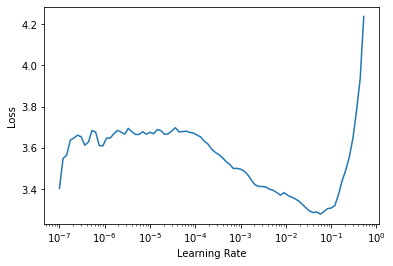

In [21]:
cifar_learner.lr_find()

In [22]:
cifar_learner.fit(10, 0.002)

epoch,train_loss,valid_loss,accuracy,time
0,1.533708,1.496142,0.469700,02:00
1,1.277314,1.328044,0.544500,02:30
2,1.156289,1.190352,0.588600,02:46
3,1.071831,1.153777,0.611000,02:48
4,0.980900,0.919124,0.685300,02:34
5,0.910749,0.893003,0.692100,02:48
6,0.868034,0.866108,0.700700,02:51
7,0.834302,0.749654,0.730600,02:55
8,0.819711,0.850965,0.712500,03:01
9,0.807329,0.787985,0.733400,02:51


epoch,train_loss,valid_loss,accuracy,time
0,0.414351,0.239195,0.923500,00:29
1,0.230613,0.344927,0.893300,00:29
2,0.203870,0.174683,0.945500,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.194690,0.192380,0.938500,00:36
1,0.156007,0.138591,0.957100,00:42
2,0.151564,0.127077,0.959800,00:35


epoch,train_loss,valid_loss,accuracy,time
0,0.160730,0.096554,0.969800,00:40
1,0.124045,0.079320,0.977700,00:34
2,0.114093,0.073571,0.977800,00:44


epoch,train_loss,valid_loss,accuracy,time
0,0.133506,0.076568,0.976500,00:38
1,0.103366,0.056024,0.983500,00:39
2,0.099932,0.058601,0.982000,00:43


epoch,train_loss,valid_loss,accuracy,time
0,0.123018,0.089515,0.972600,00:36
1,0.104468,0.052882,0.984800,00:44
2,0.089608,0.085989,0.973200,00:36


epoch,train_loss,valid_loss,accuracy,time
0,0.092038,0.073354,0.978800,00:44
1,0.100749,0.055745,0.983700,00:36
2,0.071481,0.046844,0.987300,00:42


epoch,train_loss,valid_loss,accuracy,time
0,0.097779,0.058752,0.982300,00:39
1,0.086417,0.065980,0.981300,00:44
2,0.095164,0.077147,0.978800,00:45


epoch,train_loss,valid_loss,accuracy,time
0,0.096233,0.049019,0.986700,00:45
1,0.071006,0.055357,0.984600,00:46
2,0.078344,0.050917,0.986000,00:42


epoch,train_loss,valid_loss,accuracy,time
0,0.088785,0.041219,0.989700,00:46
1,0.077672,0.069950,0.980000,00:45
2,0.065275,0.044810,0.986700,00:47


epoch,train_loss,valid_loss,accuracy,time
0,0.082974,0.063931,0.982500,00:45
1,0.067315,0.058232,0.983000,00:38
2,0.059632,0.054967,0.984300,00:47


In [23]:
import pandas as pd
import glob

In [28]:
!pwd

/home/fredguth/unb/cifar_mnist


In [39]:
all_files = glob.glob("/home/fredguth/unb/cifar_mnist/results/ex2/ex2*.csv")

In [41]:
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

In [43]:
frame = pd.concat(li, axis=0, ignore_index=True)

In [46]:
mnist_results = frame.loc[frame['epoch'] == 2]

In [49]:
mnist_results.reset_index().drop(columns=['index', 'epoch'])

,train_loss,valid_loss,accuracy,time
0,0.099932,0.058601,0.9820,00:43
1,0.071481,0.046844,0.9873,00:42
2,0.065275,0.044810,0.9867,00:47
3,0.059632,0.054967,0.9843,00:47
4,0.078344,0.050917,0.9860,00:42
5,0.089608,0.085989,0.9732,00:36
6,0.095164,0.077147,0.9788,00:45
7,0.203870,0.174683,0.9455,00:31
8,0.151564,0.127077,0.9598,00:35
9,0.114093,0.073571,0.9778,00:44


In [52]:
mnist_results.to_excel("results/ex2/ex2_mnist_results.xlsx")